Ref: 
https://stats.stackexchange.com/questions/435318/how-to-account-for-the-noof-parameters-in-the-multihead-self-attention-layer-of

In [3]:
import keras
from keras_bert import get_base_dict, get_model, compile_model, gen_batch_inputs


In [2]:

model = get_model(
    token_num=30000,
    head_num=12,
    transformer_num=2,
    embed_dim=768,
    feed_forward_dim=3072,
    seq_len=500,
    pos_num=512,
    dropout_rate=0.05
)
compile_model(model)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        [(None, 500)]        0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      [(None, 500)]        0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 500, 768), ( 23040000    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 500, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

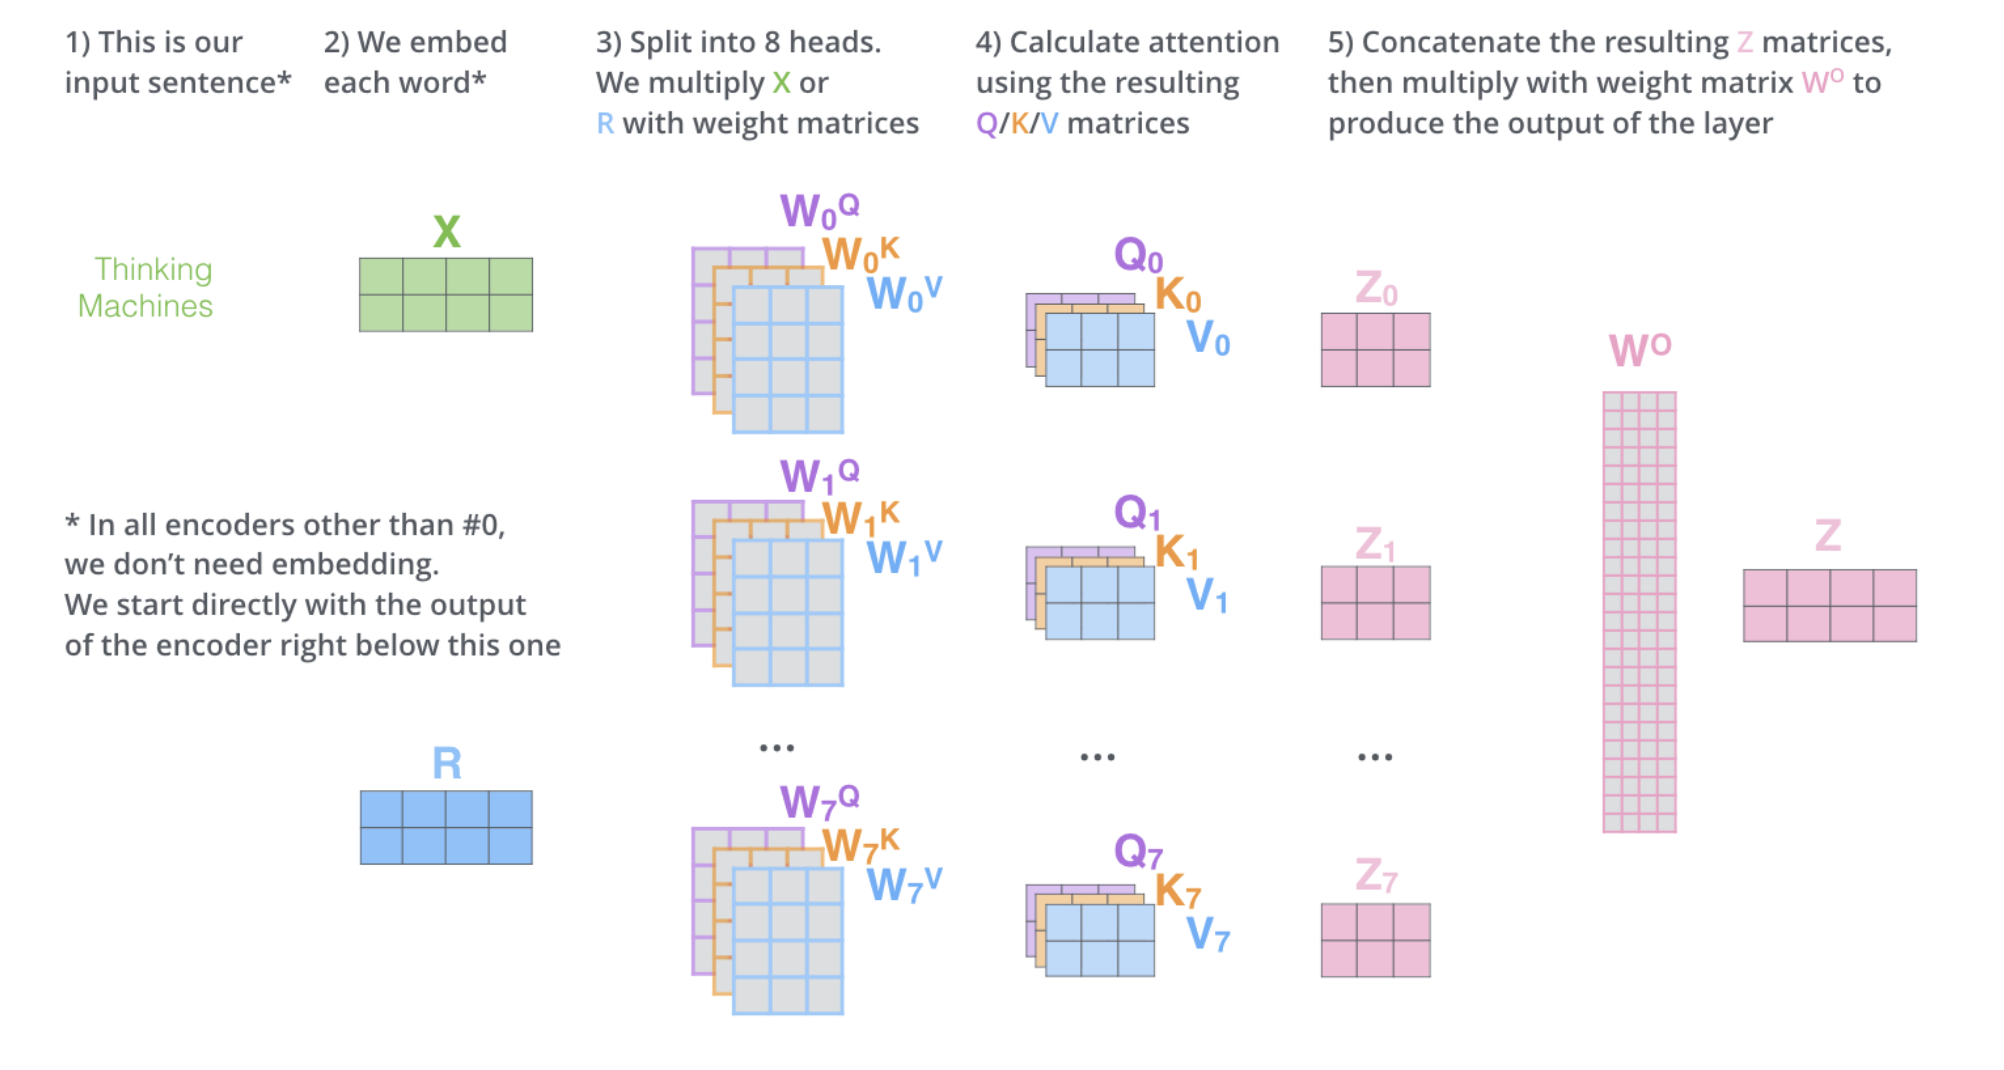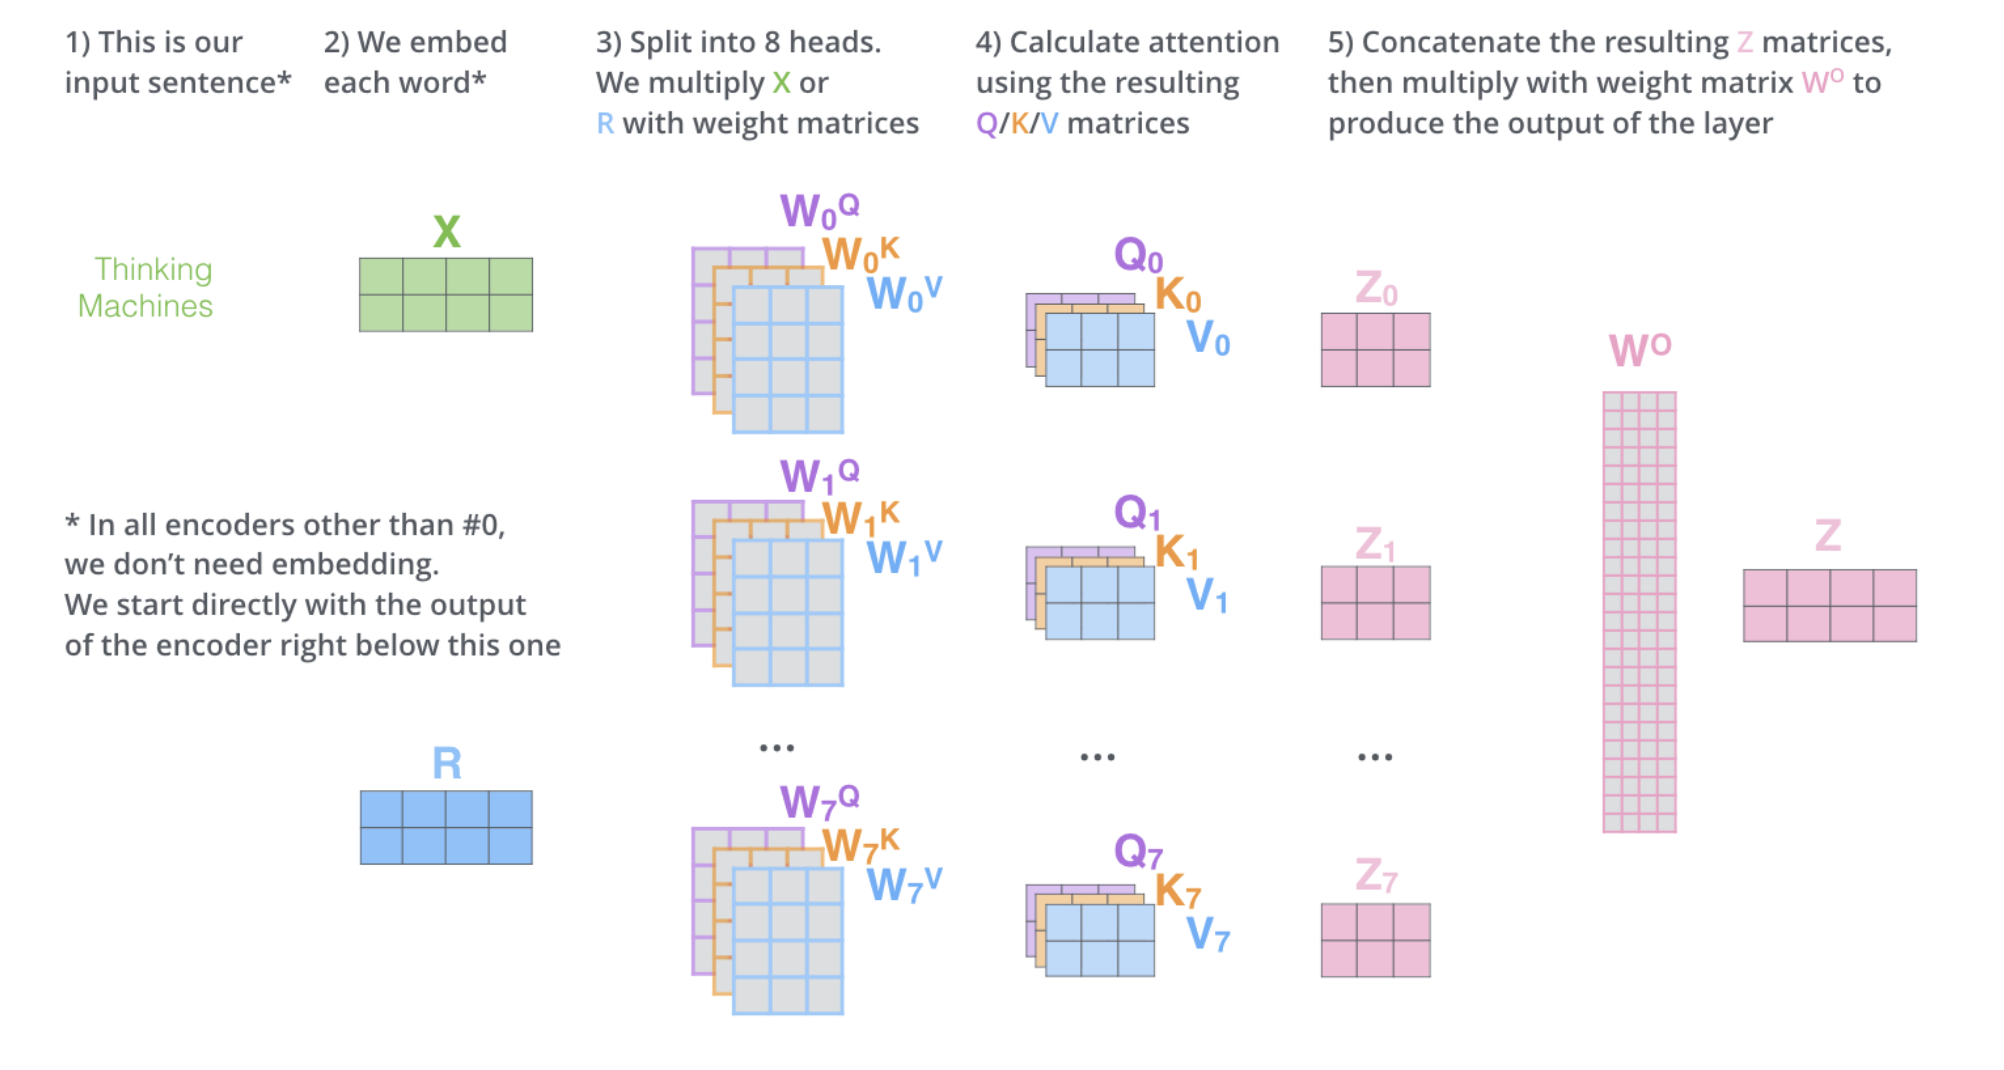


We can see the inside of transformer cell in above picture. The input vector is transformed in multiple heads, then applied the self-attention operation, then all are concatenated, and then a fully connected dense forward layer is applied. In terms of dimensions, here's how it looks:

The input vector of dimension d_model (in X) gets multiplied by three matrices $W^Q$, $W^K$, $W^V$, 12 (=attention heads, or A) times to give (3A) pairs of vectors (Q, K, V). These vectors (Z0 to Z7 in the image) are each of length d_model/A. So dimension of each of these matrices is d_model * d_model/A  and we have 3 * A such matrices.

Including the bias for eah of Q, K, V matrices, total weights till now = d_model * d_model/A * 3A + d_model * 3. By this point, we have Z0 to Zi vectors from above image. These are then concatenated, and passed through the dense layer W0 which would have dimension d_model * d_model + d_model (with bias).

So total dimension of transformer cell: A * (d_model * d_model/A) * 3 + 3* d_model  + (d_model * d_model + d_model). For BERT base, the values are A= 12, d_model = 786. So total parameters = 12 * ( 768 * 768/12) * 3 + 3*768 + 768*768 + 768  = 2,362,368



**Feed forward layer params: 4722432**
In the network, d_model = 768 and d_feedforward = 3072; The feedforward layer itself is actually two FC layers. First it projects d_model to d_feedforward ($W1$), and then it projects back to a different d_model space ($W2$).
* Dimensions of $W1$ = (d_model * d_feedforward + d_feedforward)  
* Dimensions of $W2$ = (d_feedforward * d_model + d_model)  
* Total dimensions = 768 * 3072 + 3072 + (
